生成数据集

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

评估数据集上损失值

In [2]:
# # NumPy ndarray转换为tensor
# true_w, features, poly_features, labels = [torch.tensor(x, dtype=
#     torch.float32) for x in [true_w, features, poly_features, labels]]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

训练函数

In [3]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if y_hat.ndim > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = (y_hat == y)
    return cmp.sum().item()

def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    return metric[0] / metric[2], metric[1] / metric[2]

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    if isinstance(train_features, np.ndarray):
        train_features = torch.tensor(train_features, dtype=torch.float32)
    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(train_labels, np.ndarray):
        train_labels = torch.tensor(train_labels, dtype=torch.float32)
    if isinstance(test_labels, np.ndarray):
        test_labels = torch.tensor(test_labels, dtype=torch.float32)
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    return net[0].weight.data

三阶多项式拟合

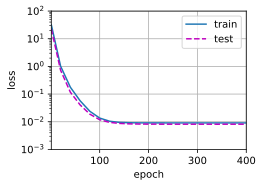

In [4]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
fit_weight = train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])
fit_weight

线性函数拟合

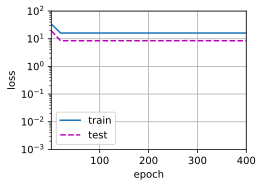

In [5]:
underfit_weight = train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])
underfit_weight

高阶多项式拟合

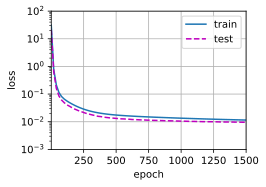

In [6]:
overfit_weight = train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)
overfit_weight

In [7]:
print(f"fit weight: {fit_weight}\n"
      f"underfit weight: {underfit_weight}\n"
      f"overfit weight: {overfit_weight}")

fit weight: tensor([[ 4.9954,  1.2024, -3.3782,  5.6027]])
underfit weight: tensor([[2.9978, 4.5835]])
overfit weight: tensor([[ 4.9842,  1.2844, -3.3175,  5.2288, -0.1291,  0.8891,  0.0530, -0.1174,
          0.1041,  0.0534, -0.0426,  0.1134,  0.0896,  0.0140, -0.1534,  0.0059,
          0.0802, -0.1261, -0.1125, -0.1283]])
